In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, trange
from nnsight import LanguageModel
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import warnings
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}


In [3]:
# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"  # Just pass string instead of torch.device
full_model_name = 'EleutherAI/gpt-j-6B'
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(
   full_model_name,
   device_map=device,  # or you can use "auto" for automatic device mapping
   torch_dtype=torch.bfloat16,
   dispatch=True,
   trust_remote_code=True  # Add this if you're still getting warnings
)
remote = False
NLAYERS = model.config.num_hidden_layers

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [4]:
def gen_math(mina = 0, maxa = 99):
   data = []
   with torch.no_grad():
       for a in tqdm(range(mina, maxa + 1)):
           for b in range(mina, maxa + 1):
               q_string = f'Output ONLY a number.\n{a}+{b}='
               q_toks = model.tokenizer(q_string)['input_ids']
               answer = a+b
               answer_tok = model.tokenizer(f'{answer}')['input_ids']
               data.append({
                   'a': a,
                   'b': b,
                   'q_string': q_string,
                   'q_tok': q_toks,
                   'answer': answer,
                   'answer_tok': answer_tok
               })
   df = pd.DataFrame(data)
   df.to_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}.pkl')
   return df

def get_gen_math(mina = 0, maxa = 99):
   return pd.read_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}.pkl')

def get_sorted_neuron_df():
   df = pd.read_csv('data_addition/neuron_att_patching.csv')
   df = df.sort_values('logit_difference', ascending=False)
   return df

def get_top_percentile_neurondf(fraction):
   df = get_sorted_neuron_df()
   n_rows = int(len(df) * fraction)
   return df.head(n_rows).reset_index(drop=True)

# s = get_gen_math()
# n = get_top_percentile_neurondf(.01)
# n



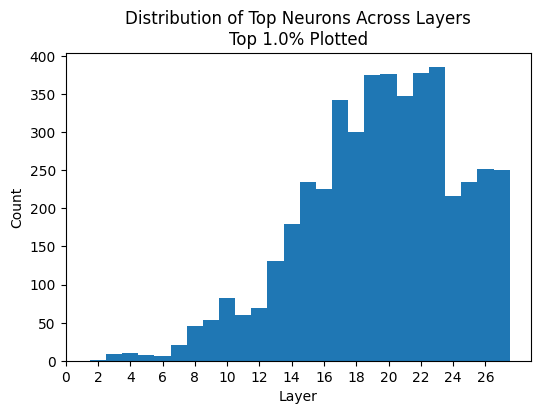

In [14]:
def plot_top_neuron_distribution(frac = 0.001):
    ndf = get_top_percentile_neurondf(frac)
    plt.figure(figsize=(6,4))
    plt.hist(ndf['layer'], bins=range(min(ndf['layer']), max(ndf['layer'])+2, 1), align='left')
    plt.xticks(range(0, NLAYERS, 2))
    plt.xlabel('Layer')
    plt.ylabel('Count')
    plt.title(f'Distribution of Top Neurons Across Layers\nTop {frac*100:.1f}% Plotted')
    plt.savefig(f'figs_addition/neuron_graphs/top_{frac*100:.1f}pct_neuron_layer_dist.png', bbox_inches='tight')
    plt.show()
plot_top_neuron_distribution(0.01)

In [4]:
def run_neuron_prepostact(mina = 0, maxa = 99, fraction = 0.01, batch_size=8, verbose = False):
   # Randomly sample num_to_use rows from df
   df = gen_math(mina = mina, maxa = maxa)
   tokens = torch.stack([torch.tensor(x) for x in df['q_tok'].values])
   answer_tokens = torch.stack([torch.tensor(x) for x in df['answer_tok'].values])[:,0]
   alla, allb = np.array(df['a'].values), np.array(df['b'])

   neurondf = get_top_percentile_neurondf(fraction)
   layer_neurons_indices = torch.stack([torch.tensor(neurondf['layer'].values), torch.tensor(neurondf['neuron_idx'].values), torch.tensor(neurondf.index.values)]).transpose(0,1)

   numa, numb = max(alla)-min(alla)+1, max(allb)-min(allb)+1
   pre_acts = np.full((len(neurondf), numa, numb), np.nan)
   post_acts = np.full((len(neurondf), numa, numb), np.nan)

   with torch.no_grad():
       for i in tqdm(range(0, len(tokens), batch_size)):
           batch_tokens = tokens[i:i+batch_size].to(device)
           batch_answers = answer_tokens[i:i+batch_size]
           batch_a, batch_b = alla[i:i+batch_size], allb[i:i+batch_size]
           mlp_pres = []
           mlp_posts = []
           with model.trace() as tracer:
               with tracer.invoke(batch_tokens) as invoker_clean:
                   for layer in range(NLAYERS):
                       mlp_pre = model.transformer.h[layer].mlp.act.input.save()
                       mlp_post = model.transformer.h[layer].mlp.act.output.save()
                       mlp_pres.append(mlp_pre)
                       mlp_posts.append(mlp_post)
           # plt.scatter(mlp_pre[0].cpu().float(), mlp_post[0].cpu().float())
           # plt.show()
           mlp_pres = torch.stack([mlp_pre[:,-1].cpu().float() for mlp_pre in mlp_pres]).transpose(0,1)
           mlp_posts = torch.stack([mlp_post[:,-1].cpu().float() for mlp_post in mlp_posts]).transpose(0,1)
           for layer_neuron_index in layer_neurons_indices:
               layer, neuron, index = layer_neuron_index
               for i in range(len(batch_a)):
                   a,b = batch_a[i], batch_b[i]
                   pre_acts[index, a, b] = mlp_pres[i,layer,neuron].item()
                   post_acts[index, a, b] = mlp_posts[i,layer,neuron].item()

   assert not np.isnan(pre_acts).any(), "Found NaN values in pre_acts"
   assert not np.isnan(post_acts).any(), "Found NaN values in post_acts"
  
   results = {
       'pre_acts': pre_acts,
       'post_acts': post_acts,
       'neurondf': neurondf
   }
   # Save using pickle instead of np.save
   with open(f'data_addition/prepost_acts/neuron_prepostact_results_mina{mina}_maxa{maxa}.pkl', 'wb') as f:
       pickle.dump(results, f)
   torch.cuda.empty_cache()
  
   return results

def get_neuron_prepostact(mina, maxa):
    with open(f'data_addition/prepost_acts/neuron_prepostact_results_mina{mina}_maxa{maxa}.pkl', 'rb') as f:
        results = pickle.load(f)
    preacts, postacts, neurondf = results['pre_acts'], results['post_acts'], results['neurondf']
    return preacts, postacts, neurondf



# Plotting Neuron Pre/Post Activations and Fourier Transforms

  0%|                                                      | 6/4587 [00:01<23:10,  3.29it/s]


KeyboardInterrupt: 

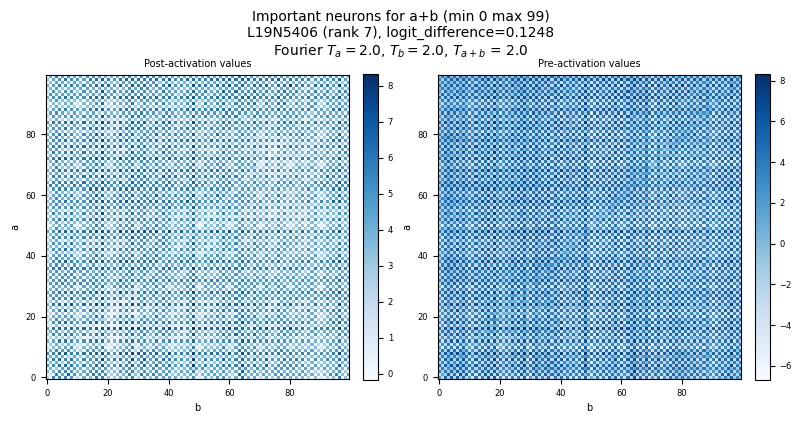

In [24]:
def find_dominant_period(preacts, idx, a_min, a_max, b_min, b_max):
    # Get the 2D function for the given index
    N_ab = torch.tensor(preacts[idx])  # Shape: (n_a, n_b)

    # Perform 2D FFT for a and b
    fft2 = torch.fft.fft2(N_ab)
    fft_shift = torch.fft.fftshift(fft2)  # Shift zero frequency to the center
    magnitude = torch.abs(fft_shift)  # Magnitude of the FFT

    # Find the dominant frequency (index of the max magnitude)
    dominant_idx = torch.argmax(magnitude).item()
    dominant_freqs = np.unravel_index(dominant_idx, magnitude.shape)

    # Compute the frequencies in the FFT grid
    n_a, n_b = N_ab.shape
    freq_a = torch.fft.fftshift(torch.fft.fftfreq(n_a, d=(a_max - a_min) / n_a))
    freq_b = torch.fft.fftshift(torch.fft.fftfreq(n_b, d=(b_max - b_min) / n_b))

    # Dominant frequencies in the a and b directions
    dominant_freq_a = freq_a[dominant_freqs[0]].item()
    dominant_freq_b = freq_b[dominant_freqs[1]].item()

    # Convert frequencies to periods
    dominant_period_a = 1 / abs(dominant_freq_a) if dominant_freq_a != 0 else float('inf')
    dominant_period_b = 1 / abs(dominant_freq_b) if dominant_freq_b != 0 else float('inf')

    a_vals, b_vals = np.meshgrid(np.arange(preacts.shape[1]), np.arange(preacts.shape[2]))
    sums = a_vals + b_vals
    xs, ys = sums.flatten(), preacts[idx].flatten()
    fft = np.fft.fft(ys - np.mean(ys))  # Center the data for better results
    freqs = np.fft.fftfreq(len(ys), d=(xs[1] - xs[0]))  # Frequency axis

    # Identify the dominant frequency
    positive_freqs = freqs[freqs > 0]  # Keep only positive frequencies
    fft_magnitudes = np.abs(fft[:len(positive_freqs)])  # Corresponding magnitudes
    dominant_freq_ab = positive_freqs[np.argmax(fft_magnitudes)]  # Frequency with maximum magnitude
    dominant_period_ab = 1 / dominant_freq_ab  # Period is the reciprocal of the frequency

    return dominant_period_a, dominant_period_b, dominant_period_ab


def plot_prepostact(mina = 0, maxa = 99):
    # Create directory if it doesn't exist
    save_dir = f'figs_addition/neuron_graphs/mina{mina}_maxa{maxa}'
    os.makedirs(save_dir, exist_ok=True)
    
    with open(f'data_addition/prepost_acts/neuron_prepostact_results_mina{mina}_maxa{maxa}.pkl', 'rb') as f:
        results = pickle.load(f)
    preacts, postacts, neurondf = results['pre_acts'], results['post_acts'], results['neurondf']
    
    # Add columns for fit parameters
    neurondf['T_a'] = np.nan
    neurondf['T_b'] = np.nan 
    neurondf['T_ab'] = np.nan
    
    for idx in tqdm(range(len(neurondf))):
        # Get neuron info
        layer = int(neurondf.iloc[idx]['layer'])
        neuron = int(neurondf.iloc[idx]['neuron_idx'])
        logit_diff = neurondf.iloc[idx]['logit_difference']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        
        # Left panel - postactivation
        im1 = ax1.imshow(postacts[idx], cmap='Blues', origin='lower')
        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        ax1.set_title('Post-activation values')
        ax1.set_xlabel('b')
        ax1.set_ylabel('a')
        
        # Middle panel - preactivation 
        im2 = ax2.imshow(preacts[idx], cmap='Blues', origin='lower')
        Ta, Tb, Tab = find_dominant_period(preacts, idx, a_min = 0, a_max = 99, b_min = 0, b_max = 99)
        # Set the period values in neurondf
        neurondf.iloc[idx, neurondf.columns.get_loc('T_a')] = Ta
        neurondf.iloc[idx, neurondf.columns.get_loc('T_b')] = Tb 
        neurondf.iloc[idx, neurondf.columns.get_loc('T_ab')] = Tab
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        ax2.set_title('Pre-activation values')
        ax2.set_xlabel('b')
        ax2.set_ylabel('a')
        
        # Add suptitle with neuron info
        plt.suptitle(f'Important neurons for a+b (min {mina} max {maxa})\nL{layer}N{neuron} (rank {idx+1}), logit_difference={logit_diff:.4f}\n'+rf'Fourier $T_a =${Ta:.1f}, $T_b = ${Tb:.1f}, $T_{{a+b}}$ = {Tab:.1f}')
        
        plt.tight_layout()
        # Save figure
        save_path = os.path.join(save_dir, f'idx{idx}_L{layer}N{neuron}.png')
        plt.savefig(save_path)
        #plt.show()
        plt.close()

   
#    # Save updated dataframe
        if idx%10 == 0:
            neurondf.to_csv(f'data_addition/prepost_acts/neuron_prepostact_mina{mina}_maxa{maxa}_fourier.csv')

plot_prepostact()



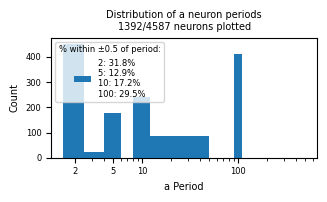

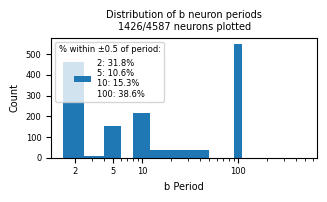

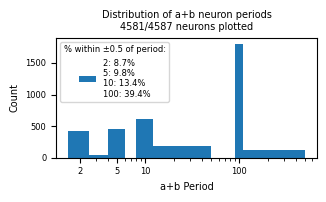

In [16]:
def plot_fourier_hist(mina, maxa):
    df = pd.read_csv(f'data_addition/prepost_acts/neuron_prepostact_mina{mina}_maxa{maxa}_fourier.csv')
    
    periods = ['T_a', 'T_b', 'T_ab']
    bins = [0, 1.5, 2.5, 4, 6, 8, 12, 50, 90, 110, 500]
    mapping = {'a':'a', 'b':'b','ab':'a+b'}
    epsilon = .05  # Tolerance for period matching
    target_periods = [2, 5, 10, 100]
    
    for period in periods:
        fig, ax = plt.subplots(figsize=(3.25, 2))
        period_name = period.split('_')[-1]
        data = df[period].replace([np.inf, -np.inf], np.nan).dropna()
        
        # Calculate percentages near target periods
        counts = []
        for target in target_periods:
            count = np.sum(np.abs(data/target - 1) <= epsilon)
            pct = count / len(data) * 100
            counts.append(f'{target}: {pct:.1f}%')
        # Plot histogram
        ax.hist(data, bins=bins, label='\n'.join(counts))
        ax.set_xscale('log')
        ax.set_xlabel(f'{mapping[period_name]} Period')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of {mapping[period_name]} neuron periods\n{len(data)}/{len(df)} neurons plotted')
        ax.set_xticks([2, 5, 10, 100])
        ax.set_xticklabels(['2', '5', '10', '100'])
        ax.legend(title='% within ±0.5 of period:', loc='upper left')
        
        plt.tight_layout()
        plt.savefig(f'figs_addition/neuron_graphs/fourier_hist_{period}_mina{mina}_maxa{maxa}.png', bbox_inches = 'tight', dpi = 300)
        plt.show()
        plt.close()

plot_fourier_hist(0,99)

# Fitting Neuron Functional Forms

In [7]:
class MultiCosineModel(nn.Module):
    def __init__(self, periods=torch.tensor([2, 5, 10, 100], dtype=torch.float)):
        super(MultiCosineModel, self).__init__()
        self.periods = periods
        num_cosine_terms = len(periods) * 3  # Three terms per period (a, b, a+b)
        # Learnable parameters for cosine terms
        self.amplitudes = nn.Parameter(torch.randn(num_cosine_terms, requires_grad=True))
        self.offsets = nn.Parameter(torch.randn(num_cosine_terms, requires_grad=True))
        # Learnable parameters for linear terms
        self.linear_weights = nn.Parameter(torch.randn(3, requires_grad=True))  # For a, b, a+b
        # Bias term
        self.bias = nn.Parameter(torch.zeros(1, requires_grad=True))

    def forward(self, a, b):
        # Rescale a, b, and a+b to [-1, 1]
        a_min, a_max = torch.min(a), torch.max(a)
        b_min, b_max = torch.min(b), torch.max(b)
        a_scaled = 2 * (a - a_min) / (a_max - a_min) - 1
        b_scaled = 2 * (b - b_min) / (b_max - b_min) - 1
        a_plus_b_scaled = a_scaled + b_scaled

        # Compute cosine terms
        a_plus_b = a + b
        cos_terms = []
        for i, T in enumerate(self.periods):
            cos_terms.append(self.amplitudes[3 * i] * torch.cos(2 * torch.pi / T * (a - self.offsets[3 * i])))
            cos_terms.append(self.amplitudes[3 * i + 1] * torch.cos(2 * torch.pi / T * (b - self.offsets[3 * i + 1])))
            cos_terms.append(self.amplitudes[3 * i + 2] * torch.cos(2 * torch.pi / T * (a_plus_b - self.offsets[3 * i + 2])))

        # Compute linear terms using the scaled values
        linear_terms = (self.linear_weights[0] * a_scaled +
                        self.linear_weights[1] * b_scaled +
                        self.linear_weights[2] * a_plus_b_scaled)

        # Combine all terms
        return sum(cos_terms) + linear_terms + self.bias

def get_neuron_idx(idx, preacts, mina, maxa):
    n_vals = preacts[idx]
    n = n_vals.shape[0] # Since n_vals is 100x100
    a_coords = torch.arange(mina, maxa+1).repeat_interleave(n)  # 0 to 99 range
    b_coords = torch.arange(mina, maxa+1).repeat(n)  # 0 to 99 range
    # Get the activation value for the specified neuron
    activations = n_vals.reshape(-1)  # Flatten to 1D
    return a_coords, b_coords, activations
    

def train(a, b, N, lr = 1e-2, epochs = 2500):
    a,b, N_actual = torch.tensor(a), torch.tensor(b), torch.tensor(N).float()
    # Initialize the model
    model = MultiCosineModel()
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.SGD(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    bar = range(epochs)
    for epoch in bar:
        # Zero the gradient buffers
        optimizer.zero_grad()
        N_pred = model(a, b)  # Pass inputs to the model
        mse_loss = criterion(N_pred, N_actual)
        loss = mse_loss# + l1_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        #bar.set_postfix({'Epoch':f'{epoch + 1}/{num_epochs}', 'Loss': f'{loss.item():.4f}'})
    N_pred = model(a,b)
    mse = torch.mean((N_pred - N_actual)**2)
    rmse = torch.sqrt(mse)
    nrmse = rmse / (torch.max(N_actual) - torch.min(N_actual))
    N_pred = N_pred.reshape(100, 100)
    return model, N_pred, nrmse

def run_cosine_fitting(mina, maxa, idx = 100, lr =1e-2, epochs = 2500):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        preacts, _, neurondf = get_neuron_prepostact(mina, maxa)
        a_coords, b_coords, activations = get_neuron_idx(idx, preacts, mina, maxa)
        row = neurondf.iloc[idx]
        L, neuronnum, log_diff = int(row['layer']), int(row['neuron_idx']), row['logit_difference']
        model, N_pred, nrmse = train(a_coords, b_coords, activations, lr = lr, epochs = epochs)
        figtitle = f'rank {idx}. L{L}N{neuronnum}. log_diff = {log_diff:.4f}<br>NRMSE: {nrmse:.4f}'
        savetitle = f'idx{idx}.L{L}N{neuronnum}'
        plot_cosine_fit(figtitle, savetitle, mina, maxa, N_pred.detach().numpy(),preacts[idx])
    return model, N_pred.detach().numpy(), nrmse.cpu().item()

def plot_cosine_fit(fig_title, save_title, mina, maxa, N_pred, N):
    # Create coordinate grids
    a_vals = np.arange(100)
    b_vals = np.arange(100)
    A, B = np.meshgrid(a_vals, b_vals)
    fig = go.Figure()

    fig.add_scatter3d(x=A.flatten(), y=B.flatten(), z=N.flatten(), 
                     mode='markers', marker=dict(size=1, color='blue', opacity=0.3), 
                     name='Original')
    fig.add_scatter3d(x=A.flatten(), y=B.flatten(), z=N_pred.flatten(),
                     mode='markers', marker=dict(size=1, color='red', opacity=0.3),
                     name='Predicted')
    fig.update_layout(
        scene = dict(
            xaxis_title='a',
            yaxis_title='b',
            zaxis_title='Value'
        ),
        width=500,
        height=500,
        title=fig_title
    )
    # Create directory if it doesn't exist
    save_dir = f'figs_addition/neuron_fits/{mina}_{maxa}'
    os.makedirs(save_dir, exist_ok=True)
    # Save figure
    fig.write_html(f'{save_dir}/{save_title}.html')
    #ig.show()

In [8]:
def run_all_cosine_fits(mina, maxa, lr = 1e-1, epochs = 2500):
    preacts, postacts, neurondf = get_neuron_prepostact(mina, maxa)
    neurondf['nrmse'] = np.nan
    neurondf['lr'] = lr
    neurondf['epochs'] = epochs
    # Create directories if they don't exist
    os.makedirs('data/neuron_fits', exist_ok=True)
    # Initialize array to store predictions
    N_predictions = np.full_like(preacts, np.nan)
    # Iterate through all neurons
    bar = tqdm(range(len(neurondf)))
    for i in bar:
        # Run fitting with specified learning rate
        model, N_pred, nrmse = run_cosine_fitting(mina, maxa, idx=i, lr=lr, epochs=epochs)
        
        # Save results
        neurondf.loc[i, 'nrmse'] = nrmse
        N_predictions[i] = N_pred
        
        # Save individual neuron results
        np.savez(f'data/neuron_fits/neuron_{i}.npz',
                 model=model.state_dict(),
                 N_pred=N_pred,
                 N_act=preacts[i])
        
        # Update progress bar
        bar.set_postfix({'idx':i,'NRMSE':f'{nrmse:.3f}'})
        
        # Every 10 iterations or on last iteration, save running results
        if (i + 1) % 10 == 0 or i == len(neurondf) - 1:
            os.makedirs('data/all_neuron_fits', exist_ok=True)
            results = {
                'N_predictions': N_predictions,
                'neurondf': neurondf,
                'preacts': preacts
            }
            with open('data/all_neuron_fits/results.pkl', 'wb') as f:
                pickle.dump(results, f)

run_all_cosine_fits(0,99)

100%|██████████████████████████████████████████████████████████████| 4587/4587 [6:25:14<00:00,  5.04s/it, idx=4586, NRMSE=0.141]


0       0.057865
1       0.058585
2       0.062802
3       0.064866
4       0.106328
          ...   
4582    0.097970
4583    0.102524
4584    0.091871
4585    0.088024
4586    0.141385
Name: nrmse, Length: 4587, dtype: float64


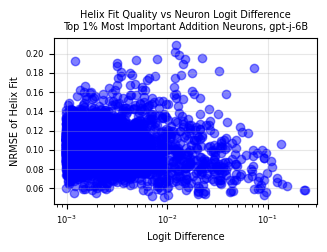

In [23]:
def read_results():
    with open('data/all_neuron_fits/results.pkl', 'rb') as f:
        results = pickle.load(f)
    Npred, ndf, preacts = results['N_predictions'], results['neurondf'], results['preacts']
    print(ndf['nrmse'])
    # Create scatter plot of logit difference vs NRMSE
    plt.figure(figsize=(3.25,2.5))
    plt.scatter(ndf['logit_difference'], ndf['nrmse'], alpha=0.5, color='blue')
    plt.xscale('log')
    plt.xlabel('Logit Difference')
    plt.ylabel('NRMSE of Helix Fit')
    plt.title(f'Helix Fit Quality vs Neuron Logit Difference\nTop 1% Most Important Addition Neurons, {MODEL_NAME}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figs_addition/neuron_fits/neuron_helix_fit_quality.png', bbox_inches = 'tight', dpi = 300)

read_results()